In [2]:
import re
import pandas as pd
import numpy as np
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
pd.set_option('display.max_colwidth', 200)

In [8]:
#spacy.cli.download("en_core_web_sm")

nlp = spacy.load('en_core_web_sm')

In [9]:
data = pd.read_csv("wiki_sentences_v2.csv")
data.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [10]:
data.shape

(4318, 1)

In [11]:
# Nodes & Edges
# Nodes - Entities (Subject & Object)
# Edges - Relation b/w the entities

# The main idea is to go through a sentence,
# and extract the subject and the object as and when they are encountered (even multi words)

In [28]:
myList = ["python","hub"]
for i in range myList:
myList.append(i.upper())
print(myList)

SyntaxError: invalid syntax (211811078.py, line 2)

In [12]:
def get_dependency_tags(data) -> list[dict]:   # tags only the individual words as subjects/objects
    dependancy_tags = []
    for sent in tqdm(data["sentence"]):
        doc = nlp(sent)
        dependancy_tags.append({tok.text:tok.dep_ for tok in doc})
    return dependancy_tags

In [13]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
    for tok in nlp(sent): 
        if tok.dep_ != "punct":  # if token is a punctuation mark then move on to the next token
            if tok.dep_ == "compound":   # check 1: token is a compound word or not
                prefix = tok.text
                if prv_tok_dep == "compound":   # if the previous word was also a 'compound' then add the current word to it
                    prefix = prv_tok_text + " "+ tok.text
                    
            if tok.dep_.endswith("mod") == True:  # check 2: token is a modifier or not
                modifier = tok.text
                if prv_tok_dep == "compound":  
                    modifier = prv_tok_text + " "+ tok.text
                    
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = "" 
                
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
                
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    return [ent1.strip(), ent2.strip()]

In [14]:
def get_entity_pairs(data):
    entity_pairs = []
    for i in tqdm(data["sentence"]):
        entity_pairs.append(get_entities(i))
    return entity_pairs

In [15]:
def get_relations(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)   # Matcher class object 

    pattern = [{'DEP':'ROOT'},     #define the pattern 
        {'DEP':'prep','OP':"?"},
        {'DEP':'agent','OP':"?"},  
        {'POS':'ADJ','OP':"?"}] 

    matcher.add('match', [pattern]) 
    matches = matcher(doc)

    if len(matches):
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return span.text
    else:
        return None

In [16]:
dependancy_tags = get_dependency_tags(data)

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:09<00:00, 61.84it/s]


In [26]:
dependancy_tags

[{'confused': 'advcl',
  'and': 'cc',
  'frustrated': 'conj',
  ',': 'punct',
  'connie': 'nsubj',
  'decides': 'ROOT',
  'to': 'aux',
  'leave': 'xcomp',
  'on': 'prep',
  'her': 'poss',
  'own': 'pobj',
  '.': 'punct'},
 {'later': 'advmod',
  ',': 'punct',
  'a': 'det',
  'woman': 'poss',
  '’s': 'case',
  'scream': 'nsubjpass',
  'is': 'auxpass',
  'heard': 'ROOT',
  'in': 'prep',
  'the': 'det',
  'distance': 'pobj',
  '.': 'punct'},
 {'christian': 'nsubjpass',
  'is': 'auxpass',
  'then': 'advmod',
  'paralyzed': 'ROOT',
  'by': 'agent',
  'an': 'det',
  'elder': 'pobj',
  '.': 'punct'},
 {'the': 'det',
  'temple': 'nsubjpass',
  'is': 'auxpass',
  'set': 'ROOT',
  'on': 'prep',
  'fire': 'pobj',
  '.': 'punct'},
 {'outside': 'advmod',
  ',': 'punct',
  'the': 'det',
  'cult': 'compound',
  'wails': 'ROOT',
  'with': 'prep',
  'him': 'pobj',
  '.': 'punct'},
 {'it': 'nsubj',
  "'s": 'case',
  'a': 'det',
  'parable': 'attr',
  'of': 'prep',
  'woman': 'poss',
  'religious': 'amod'

In [17]:
entity_pairs = get_entity_pairs(data)

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:11<00:00, 60.71it/s]


In [18]:
relations = [get_relations(i) for i in tqdm(data['sentence'])]

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:07<00:00, 63.58it/s]


In [19]:
entity_pairs

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'outside cult him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men'],
 ['last  which', 'penn'],
 ['jessica chastain', 'same  character'],
 ['mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'studios motion pictures'],
 ['it', '$ 103.7 million'],
 ['millie thomas aisha', ''],
 ['it', 'executive producer yoshimitsu banno'],
 ['vivienn

In [20]:
relations

['decides',
 'heard in',
 'paralyzed by',
 'set on',
 'wails with',
 "'s",
 'joined',
 'revealed',
 'revealed as',
 'tried',
 'went through',
 'circling',
 'supervised',
 'features',
 'is',
 'injures',
 'tasked with',
 'attacked by',
 'portrays',
 'return',
 'stand',
 'considered for',
 'served as',
 'completed on',
 'released',
 'released',
 'distributed by',
 'ended',
 'chandler',
 'dedicated to executive',
 'approach former',
 'frees',
 'disowns',
 'appears as',
 'credited as',
 'stated',
 'empathizing with',
 'was',
 'contributed to',
 'took',
 'changed',
 'became',
 'look like big',
 'perform',
 'managed',
 'released on',
 'written by',
 'conducted by',
 'released',
 'released',
 'scheduled',
 'offered in',
 'includes',
 'include',
 'are ready',
 'was',
 'tend',
 'include',
 'themes',
 'is',
 'are',
 'had many',
 'supervises',
 'oversee',
 'credited',
 'start in',
 'started as',
 'attended',
 'use different',
 'take',
 'equipped with sound',
 'designed for',
 'cooperates with',
 '

In [21]:
relations.count(None)

0

In [22]:
pd.Series(relations).value_counts()[:10]

is             364
was            308
released on     90
are             74
include         73
were            68
released        41
's              39
composed by     34
became          31
dtype: int64

# Building KG

In [23]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with


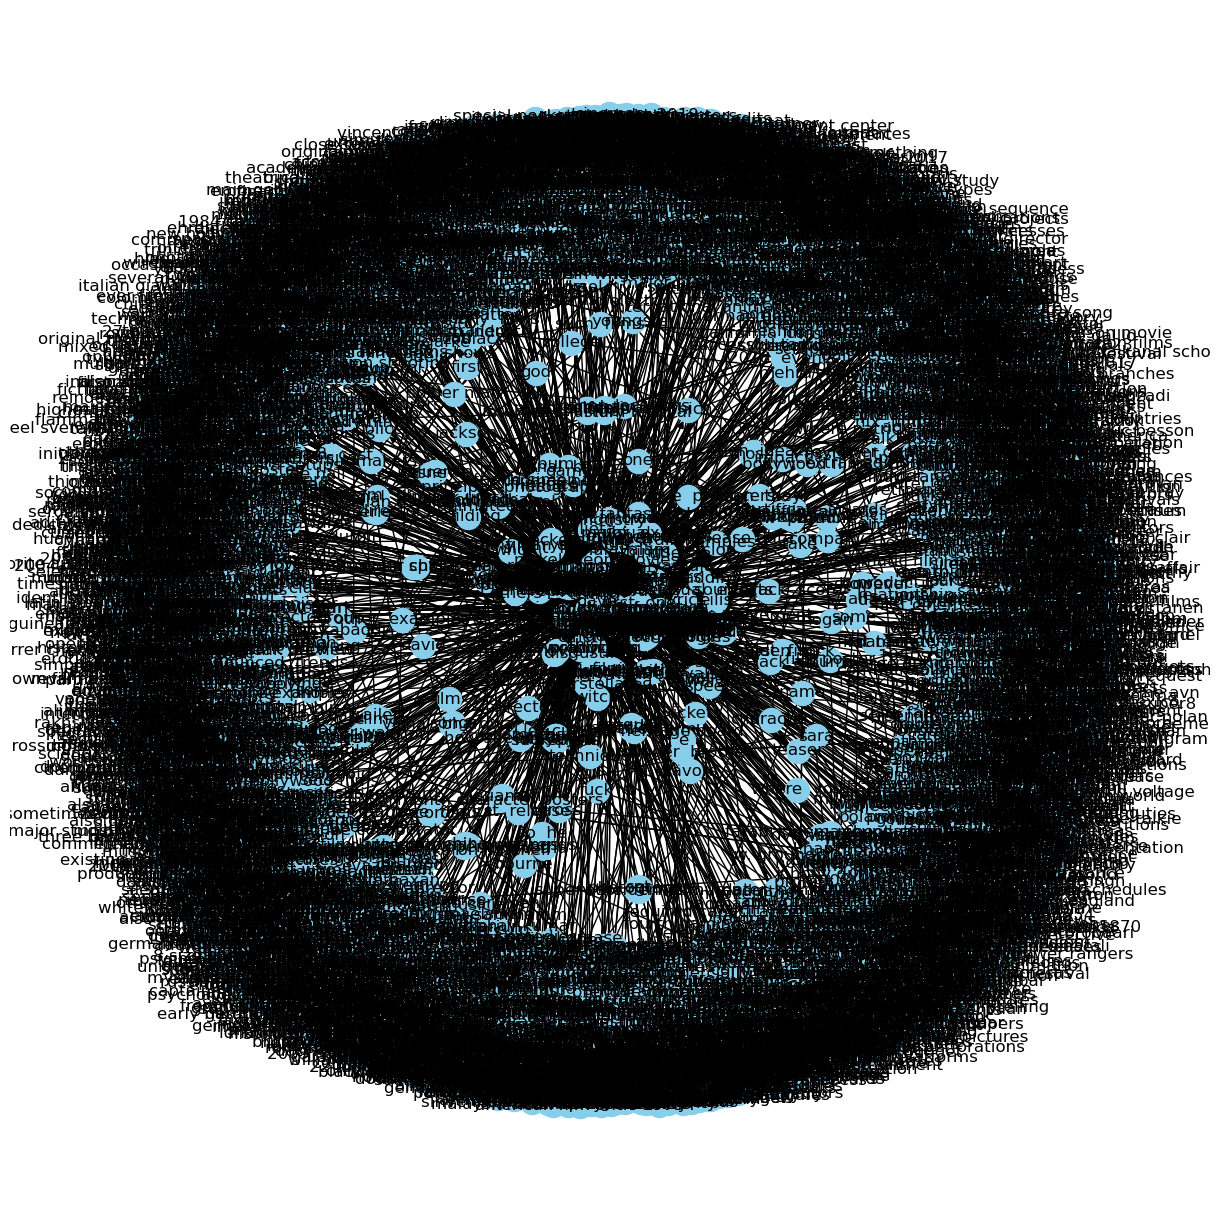

<Figure size 640x480 with 0 Axes>

In [29]:
# create a directed-graph from the dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


# plot KG
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
plt.savefig('kg.png')

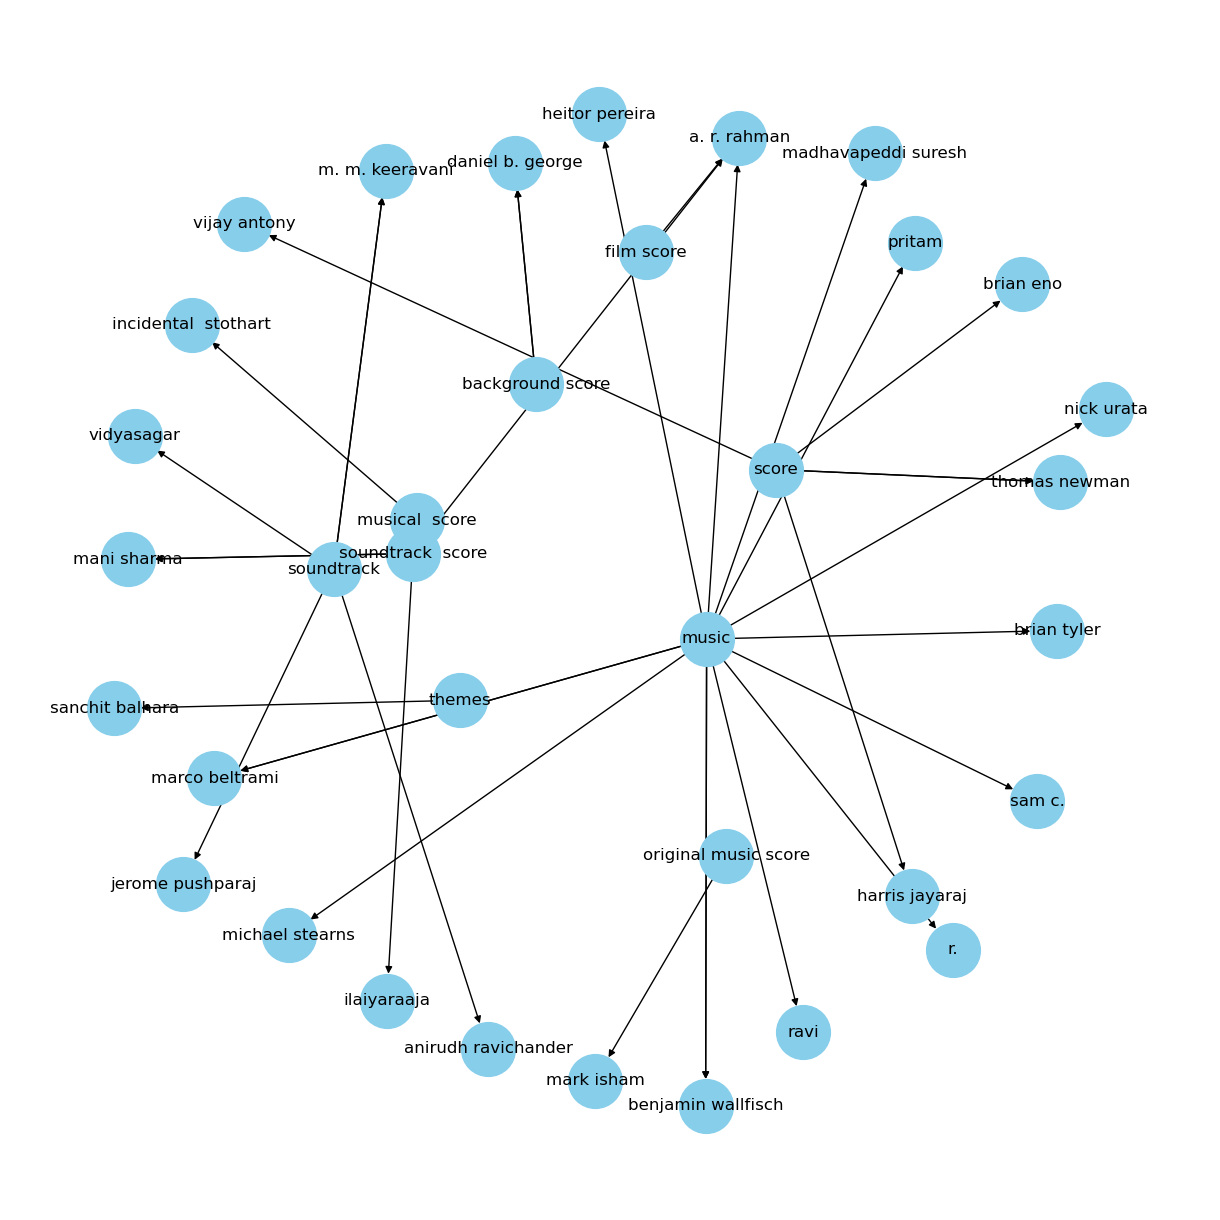

<Figure size 640x480 with 0 Axes>

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
plt.savefig('kg1.png')